In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=DeprecationWarning) 
warnings.simplefilter("ignore", UserWarning)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

njobs = -1

In [24]:
train=pd.read_csv('../../1. Task and Data/train.csv',sep='|')

In [25]:
print(train.fraud.value_counts())
print(train.fraud.value_counts() / len(train))

0    1775
1     104
Name: fraud, dtype: int64
0    0.944651
1    0.055349
Name: fraud, dtype: float64


# Feature Engineering

In [26]:
train['scannedLineItems'] = train['scannedLineItemsPerSecond'] * train['totalScanTimeInSeconds']
train['pricePerScannedLineItem'] = train['grandTotal'] / train['scannedLineItems']
train['scansWithoutRegistrationPerScannedLineItem'] = train['scansWithoutRegistration'] / train['scannedLineItems']
train['quantityModificationsPerScannedLineItem'] = train['quantityModifications'] / train['scannedLineItems']
train['lineItemVoidsPerSecond'] = train['lineItemVoids'] / train['totalScanTimeInSeconds']
train['scansWithoutRegistrationPerSecond'] = train['scansWithoutRegistration'] / train['totalScanTimeInSeconds']
train['quantityModificationsPerSecond'] = train['quantityModifications'] / train['totalScanTimeInSeconds']
train['secondsPerEuro'] = train['totalScanTimeInSeconds'] / train['grandTotal']
train['lineItemVoidsPerEuro'] = train['lineItemVoids'] / train['grandTotal']
train['scansWithoutRegistrationPerEuro'] = train['scansWithoutRegistration'] / train['grandTotal']
train['quantityModificationsPerEuro'] = train['quantityModifications'] / train['grandTotal']

In [27]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer


def my_custom_loss_func(y_true, y_pred):
    cm = confusion_matrix(y_true,y_pred)
    tn, fp, fn, tp = cm.ravel()
    score = ((-25)*fp + (-5)*fn + 5*tp) / len(y_true)
    return (score)

my_custom_score = make_scorer(my_custom_loss_func, greater_is_better=True)

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import LeaveOneOut

skf = StratifiedKFold(n_splits=10)

# Model factory

In [28]:
from sklearn.tree import ExtraTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble.forest import ExtraTreesClassifier
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble.bagging import BaggingClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


model_tuning_factory = [
    GridSearchCV(BaggingClassifier(),
                 dict(n_estimators = [5, 10, 20, 50, 100, 150, 200],
                      base_estimator = [DecisionTreeClassifier(max_depth=1), # default setting for AdaBoost
                                        LogisticRegression(),
                                        ExtraTreesClassifier(),
                              #          GradientBoostingClassifier(), # takes a long time (-> + 30 sec)
                              #          RandomForestClassifier(),  # takes a long time (-> + 30 sec)
                                        DecisionTreeClassifier(),
                                        ExtraTreeClassifier(),
                                        None]),   # standard -> 'Decision Tree'
                 cv = skf,
                 scoring = my_custom_score,
                n_jobs = -1)
]           
                 
                 
iterations = 100                 
               
model_tuning_factory_randomized = [
    RandomizedSearchCV(BaggingClassifier(),
                 dict(n_estimators = [5, 10, 20, 50, 100, 150, 200],
                      base_estimator = [DecisionTreeClassifier(max_depth=1), # default setting for AdaBoost
                                        LogisticRegression(),
                                        ExtraTreesClassifier(),
                              #          GradientBoostingClassifier(), # takes a long time (-> + 30 sec)
                              #          RandomForestClassifier(),  # takes a long time (-> + 30 sec)
                                        DecisionTreeClassifier(),
                                        ExtraTreeClassifier(),
                                        None]),   # standard -> 'Decision Tree'
                 cv = skf,
                 scoring = my_custom_score,
                      n_iter  = iterations,
                      n_jobs = -1)
]

In [29]:
Y = train['fraud']
X = train.drop('fraud',axis=1)

In [30]:
import time
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE

from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

result_table = pd.DataFrame(columns=["Model", "Data Preparation", "Feature Count", "Feature Selection Technique", "Features", "Optimal Parameters", "Monetary Value Per Instance - Mean", "Monetary Value Per Instance - Standard Deviation", "Raw Model"])


for data_preparation_strategy in range(1,5):
    if (data_preparation_strategy == 1):  
        X_scaled = X
        data_preparation = "No Scaling"
    elif (data_preparation_strategy == 2):
        feature_scaler = MinMaxScaler()  
        X_scaled = pd.DataFrame(feature_scaler.fit_transform(X.values), columns=X.columns, index=X.index) 
        data_preparation = "MinMaxScaler"
    elif (data_preparation_strategy == 3):
        feature_scaler = StandardScaler()  
        X_scaled = pd.DataFrame(feature_scaler.fit_transform(X.values), columns=X.columns, index=X.index)
        data_preparation = "StandardScaler"
    elif (data_preparation_strategy == 4):
        transformer = FunctionTransformer(np.log1p, validate=True)  
        X_scaled = pd.DataFrame(transformer.transform(X), columns=X.columns, index=X.index)
        data_preparation = "LogScaler"    

    for model in model_tuning_factory:   # replace with model_tuning_factory_randomized for faster results


        for feature_count in range(1,len(list(X))+1):

            model.seed = 42
            start_time = time.time()              


            # Solution with SelectKBest
            best_features = SelectKBest(f_classif, k=feature_count).fit(X_scaled,Y)
            best_feature_list = X.columns[best_features.get_support()]
            X_selected_features = X[best_feature_list]

            model.fit(X_selected_features,Y)  
            model_name = model.best_estimator_.__class__.__name__
            score_mean = model.cv_results_['mean_test_score'][model.best_index_]
            score_std = model.cv_results_['std_test_score'][model.best_index_]

            result_table = result_table.append({
             "Model": model_name, 
             "Data Preparation": data_preparation,   
             "Feature Count": feature_count,
             "Feature Selection Technique": "SelectKBest",   
             "Features": best_feature_list.values, 
             "Optimal Parameters": model.best_params_,
             "Monetary Value Per Instance - Mean":  score_mean,
             "Monetary Value Per Instance - Standard Deviation": score_std,   
             "Raw Model": model.best_estimator_
              }, ignore_index=True)


            # Solution with Recursive Feature Elimination -> only works for some models

            if (model.estimator.__class__.__name__ == 'LogisticRegression'
             or model.estimator.__class__.__name__ == 'DecisionTreeClassifier'
             or model.estimator.__class__.__name__ == 'ExtraTreeClassifier'
             or model.estimator.__class__.__name__ == 'ExtraTreesClassifier'
             or model.estimator.__class__.__name__ == 'RandomForestClassifier'
             or model.estimator.__class__.__name__ == 'BernoulliNB'
             or model.estimator.__class__.__name__ == 'AdaBoostClassifier'
             or model.estimator.__class__.__name__ == 'GradientBoostingClassifier'
             or model.estimator.__class__.__name__ == 'Perceptron'
             or model.estimator.__class__.__name__ == 'LinearDiscriminantAnalysis'):

               # Traditional RFE
                rfe = RFE(model.estimator, n_features_to_select = feature_count)
                rfe = rfe.fit(X,Y)
                best_feature_list = np.array(list(X))[np.array(rfe.support_)]
                X_selected_features = X[best_feature_list]

                model.fit(X_selected_features,Y)  
                model_name = model.best_estimator_.__class__.__name__
                score_mean = model.cv_results_['mean_test_score'][model.best_index_]
                score_std = model.cv_results_['std_test_score'][model.best_index_]


                result_table = result_table.append({
                 "Model": model_name, 
                 "Data Preparation": data_preparation,
                 "Feature Count": feature_count,
                 "Feature Selection Technique": "RFE",
                 "Features": best_feature_list,
                 "Optimal Parameters": model.best_params_,
                 "Monetary Value Per Instance - Mean":  score_mean,
                 "Monetary Value Per Instance - Standard Deviation": score_std,  
                 "Raw Model": model.best_estimator_
                  }, ignore_index=True)

            end_time = time.time()

            print("Finished " + model.best_estimator_.__class__.__name__ + " with " + data_preparation + " and " + str(feature_count) + " features after " + str(round(end_time - start_time, 2)) + " seconds")



        if (model.estimator.__class__.__name__ == 'LogisticRegression'
         or model.estimator.__class__.__name__ == 'DecisionTreeClassifier'
         or model.estimator.__class__.__name__ == 'ExtraTreeClassifier'
         or model.estimator.__class__.__name__ == 'ExtraTreesClassifier'
         or model.estimator.__class__.__name__ == 'RandomForestClassifier'
         or model.estimator.__class__.__name__ == 'BernoulliNB'
         or model.estimator.__class__.__name__ == 'AdaBoostClassifier'
         or model.estimator.__class__.__name__ == 'GradientBoostingClassifier'
         or model.estimator.__class__.__name__ == 'Perceptron'
         or model.estimator.__class__.__name__ == 'LinearDiscriminantAnalysis'):

            # RFE with Cross Validation -> determines the optimum feature count automatically
            rfecv = RFECV(model.estimator, cv = skf, scoring = my_custom_score)
            rfecv = rfe.fit(X,Y)
            best_feature_list = np.array(list(X))[np.array(rfecv.support_)]
            X_selected_features = X[best_feature_list]

            model.fit(X_selected_features,Y)  
            model_name = model.best_estimator_.__class__.__name__
            score_mean = model.cv_results_['mean_test_score'][model.best_index_]
            score_std = model.cv_results_['std_test_score'][model.best_index_]


            result_table = result_table.append({
             "Model": model_name,  
             "Data Preparation": data_preparation,
             "Feature Count": len(best_feature_list),
             "Feature Selection Technique": "RFECV",
             "Features": best_feature_list,
             "Optimal Parameters": model.best_params_,
             "Monetary Value Per Instance - Mean":  score_mean,
             "Monetary Value Per Instance - Standard Deviation": score_std,    
             "Raw Model": model.best_estimator_
              }, ignore_index=True)

result_table.sort_values(by = "Monetary Value Per Instance - Mean", ascending = False)

Finished BaggingClassifier with No Scaling and 1 features after 32.51 seconds
Finished BaggingClassifier with No Scaling and 2 features after 35.44 seconds
Finished BaggingClassifier with No Scaling and 3 features after 39.53 seconds
Finished BaggingClassifier with No Scaling and 4 features after 22.03 seconds
Finished BaggingClassifier with No Scaling and 5 features after 34.89 seconds
Finished BaggingClassifier with No Scaling and 6 features after 30.8 seconds
Finished BaggingClassifier with No Scaling and 7 features after 52.02 seconds
Finished BaggingClassifier with No Scaling and 8 features after 42.84 seconds
Finished BaggingClassifier with No Scaling and 9 features after 40.44 seconds
Finished BaggingClassifier with No Scaling and 10 features after 49.6 seconds
Finished BaggingClassifier with No Scaling and 11 features after 45.13 seconds
Finished BaggingClassifier with No Scaling and 12 features after 67.67 seconds
Finished BaggingClassifier with No Scaling and 13 features afte

,Model,Data Preparation,Feature Count,Feature Selection Technique,Features,Optimal Parameters,Monetary Value Per Instance - Mean,Monetary Value Per Instance - Standard Deviation,Raw Model
70,BaggingClassifier,LogScaler,11,SelectKBest,"[trustLevel, totalScanTimeInSeconds, lineItemV...",{'base_estimator': ExtraTreeClassifier(class_w...,0.114423,0.077750,"(ExtraTreeClassifier(class_weight=None, criter..."
51,BaggingClassifier,StandardScaler,12,SelectKBest,"[trustLevel, totalScanTimeInSeconds, lineItemV...",{'base_estimator': ExtraTreesClassifier(bootst...,0.106440,0.085583,"((ExtraTreeClassifier(class_weight=None, crite..."
7,BaggingClassifier,No Scaling,8,SelectKBest,"[trustLevel, totalScanTimeInSeconds, scansWith...",{'base_estimator': ExtraTreesClassifier(bootst...,0.103779,0.098962,"((ExtraTreeClassifier(class_weight=None, crite..."
35,BaggingClassifier,MinMaxScaler,16,SelectKBest,"[trustLevel, totalScanTimeInSeconds, lineItemV...",{'base_estimator': ExtraTreesClassifier(bootst...,0.101118,0.090247,"((ExtraTreeClassifier(class_weight=None, crite..."
29,BaggingClassifier,MinMaxScaler,10,SelectKBest,"[trustLevel, totalScanTimeInSeconds, lineItemV...",{'base_estimator': ExtraTreeClassifier(class_w...,0.101118,0.074764,"(ExtraTreeClassifier(class_weight=None, criter..."
11,BaggingClassifier,No Scaling,12,SelectKBest,"[trustLevel, totalScanTimeInSeconds, lineItemV...",{'base_estimator': ExtraTreeClassifier(class_w...,0.101118,0.064778,"(ExtraTreeClassifier(class_weight=None, criter..."
49,BaggingClassifier,StandardScaler,10,SelectKBest,"[trustLevel, totalScanTimeInSeconds, lineItemV...",{'base_estimator': ExtraTreesClassifier(bootst...,0.101118,0.085315,"((ExtraTreeClassifier(class_weight=None, crite..."
28,BaggingClassifier,MinMaxScaler,9,SelectKBest,"[trustLevel, totalScanTimeInSeconds, lineItemV...",{'base_estimator': ExtraTreeClassifier(class_w...,0.098457,0.094317,"(ExtraTreeClassifier(class_weight=None, criter..."
31,BaggingClassifier,MinMaxScaler,12,SelectKBest,"[trustLevel, totalScanTimeInSeconds, lineItemV...",{'base_estimator': ExtraTreeClassifier(class_w...,0.098457,0.078702,"(ExtraTreeClassifier(class_weight=None, criter..."
71,BaggingClassifier,LogScaler,12,SelectKBest,"[trustLevel, totalScanTimeInSeconds, lineItemV...",{'base_estimator': ExtraTreesClassifier(bootst...,0.095796,0.070299,"((ExtraTreeClassifier(class_weight=None, crite..."


In [31]:
result_table.sort_values(by = "Monetary Value Per Instance - Mean", ascending = False)

,Model,Data Preparation,Feature Count,Feature Selection Technique,Features,Optimal Parameters,Monetary Value Per Instance - Mean,Monetary Value Per Instance - Standard Deviation,Raw Model
70,BaggingClassifier,LogScaler,11,SelectKBest,"[trustLevel, totalScanTimeInSeconds, lineItemV...",{'base_estimator': ExtraTreeClassifier(class_w...,0.114423,0.077750,"(ExtraTreeClassifier(class_weight=None, criter..."
51,BaggingClassifier,StandardScaler,12,SelectKBest,"[trustLevel, totalScanTimeInSeconds, lineItemV...",{'base_estimator': ExtraTreesClassifier(bootst...,0.106440,0.085583,"((ExtraTreeClassifier(class_weight=None, crite..."
7,BaggingClassifier,No Scaling,8,SelectKBest,"[trustLevel, totalScanTimeInSeconds, scansWith...",{'base_estimator': ExtraTreesClassifier(bootst...,0.103779,0.098962,"((ExtraTreeClassifier(class_weight=None, crite..."
35,BaggingClassifier,MinMaxScaler,16,SelectKBest,"[trustLevel, totalScanTimeInSeconds, lineItemV...",{'base_estimator': ExtraTreesClassifier(bootst...,0.101118,0.090247,"((ExtraTreeClassifier(class_weight=None, crite..."
29,BaggingClassifier,MinMaxScaler,10,SelectKBest,"[trustLevel, totalScanTimeInSeconds, lineItemV...",{'base_estimator': ExtraTreeClassifier(class_w...,0.101118,0.074764,"(ExtraTreeClassifier(class_weight=None, criter..."
11,BaggingClassifier,No Scaling,12,SelectKBest,"[trustLevel, totalScanTimeInSeconds, lineItemV...",{'base_estimator': ExtraTreeClassifier(class_w...,0.101118,0.064778,"(ExtraTreeClassifier(class_weight=None, criter..."
49,BaggingClassifier,StandardScaler,10,SelectKBest,"[trustLevel, totalScanTimeInSeconds, lineItemV...",{'base_estimator': ExtraTreesClassifier(bootst...,0.101118,0.085315,"((ExtraTreeClassifier(class_weight=None, crite..."
28,BaggingClassifier,MinMaxScaler,9,SelectKBest,"[trustLevel, totalScanTimeInSeconds, lineItemV...",{'base_estimator': ExtraTreeClassifier(class_w...,0.098457,0.094317,"(ExtraTreeClassifier(class_weight=None, criter..."
31,BaggingClassifier,MinMaxScaler,12,SelectKBest,"[trustLevel, totalScanTimeInSeconds, lineItemV...",{'base_estimator': ExtraTreeClassifier(class_w...,0.098457,0.078702,"(ExtraTreeClassifier(class_weight=None, criter..."
71,BaggingClassifier,LogScaler,12,SelectKBest,"[trustLevel, totalScanTimeInSeconds, lineItemV...",{'base_estimator': ExtraTreesClassifier(bootst...,0.095796,0.070299,"((ExtraTreeClassifier(class_weight=None, crite..."


In [33]:
#result_table.to_pickle("result_table_BaggingClassifier.pkl")
result_table = pd.read_pickle("result_table_BaggingClassifier.pkl")

Text(0, 0.5, 'Monetary Value Per Instance - Mean')

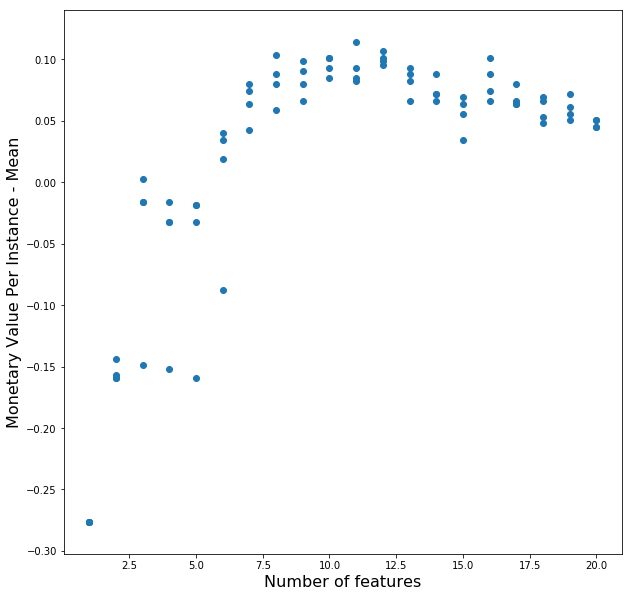

In [34]:
plt.rcParams['figure.figsize'] = (10,10)

plt.scatter(result_table["Feature Count"], result_table["Monetary Value Per Instance - Mean"])
plt.xlabel('Number of features', fontsize=16)
plt.ylabel('Monetary Value Per Instance - Mean', fontsize=16)

In [35]:
best_model = result_table.loc[result_table["Monetary Value Per Instance - Mean"].argmax()]["Raw Model"]
best_model_features = result_table.loc[result_table["Monetary Value Per Instance - Mean"].argmax()]["Features"]
best_parameters = result_table.loc[result_table["Monetary Value Per Instance - Mean"].argmax()]["Optimal Parameters"]

print(best_model)
print(best_model_features)
print(best_parameters)

BaggingClassifier(base_estimator=ExtraTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, random_state=None,
          splitter='random'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=200, n_jobs=None, oob_score=False,
         random_state=None, verbose=0, warm_start=False)
['trustLevel' 'totalScanTimeInSeconds' 'lineItemVoids'
 'scansWithoutRegistration' 'valuePerSecond' 'lineItemVoidsPerPosition'
 'scannedLineItems' 'pricePerScannedLineItem'
 'scansWithoutRegistrationPerScannedLineItem'
 'quantityModificationsPerScannedLineItem' 'secondsPerEuro']
{'base_estimator': ExtraTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_im

In [36]:
from sklearn.metrics import confusion_matrix

def get_monetary_value(cm):
        tn, fp, fn, tp = cm.ravel()
        print("True negative: ", tn)
        print("False positive: ", fp)
        print("False negative: ", fn)
        print("True positive: ", tp)
        score = (-25)*fp + (-5)*fn + 5*tp
        print(str(score) + " for " + str(sum(sum(cm))) + " instances in the test set")
        print(str(score/sum(sum(cm))) + " per instance in the test set")
        return score
    
cm = confusion_matrix(Y , best_model.predict(X[best_model_features]))

monetary_value = get_monetary_value(cm)

True negative:  1775
False positive:  0
False negative:  0
True positive:  104
520 for 1879 instances in the test set
0.2767429483767962 per instance in the test set
